## Imports

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from datetime import datetime

In [2]:
from ema_workbench import (
    Model,
    Policy,
    Scenario,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)

from ema_workbench.analysis import parcoords
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

## EMA Workbench Setup

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

# Model with 5 outcomes, for filtering outcome columns in results
model, planning_steps = get_model_for_problem_formulation(7)
# Model with 13 outcomes, neccesary to apply the constraits
model_constraints, planning_steps = get_model_for_problem_formulation(8)

## Policies

In [4]:
# if you choose file 'output/20230614T1059_results_seed_ds', which has 18 policies,
# then you can see that the notebook works correctly.
INPUT_FILENAME = 'output/20230614T1059_results_seed_ds_pareto'

In [5]:
df = pd.read_csv(INPUT_FILENAME + '.csv')

In [6]:
policies = df
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,Unnamed: 0.1,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,1,0,0,0,0,0,0,...,2,0,0,6,5,3,5,5,5,0
1,1,1,0,1,0,0,0,0,0,0,...,4,1,1,3,3,0,4,4,2,0
2,2,2,0,0,0,0,0,0,1,1,...,4,8,2,1,6,1,1,5,0,4
3,3,3,0,1,0,0,0,0,1,0,...,5,1,3,6,4,1,4,5,1,0


In [7]:
policies_to_evaluate = []

for _, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(_), **policy.to_dict()))

In [8]:
# baseline policy, needed for for relative constraits
zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})
pol0 = {}

for key in model_constraints.levers:
    s1, s2 = key.name.split("_")
    pol0.update({key.name: zero_policy[s2]})

policy0 = Policy("Policy 0", **pol0)
policies_to_evaluate.append(policy0)

In [9]:
policies_to_evaluate

[Policy({'Unnamed: 0.1': 0, 'Unnamed: 0': 0, '0_RfR 0': 0, '0_RfR 1': 1, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 3, 'A.1_DikeIncrease 0': 5, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 7, 'A.2_DikeIncrease 1': 3, 'A.2_DikeIncrease 2': 2, 'A.3_DikeIncrease 0': 0, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 6, 'A.4_DikeIncrease 0': 5, 'A.4_DikeIncrease 1': 3, 'A.4_DikeIncrease 2': 5, 'A.5_DikeIncrease 0': 5, 'A.5_DikeIncrease 1': 5, 'A.5_DikeIncrease 2': 0}),
 Policy({'Unnamed: 0.1': 1, 'Unnamed: 0': 1, '0_RfR 0': 0, '0_RfR 1': 1, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 4, 'A.1_DikeIncrease 0': 1, 'A.1_DikeIncrease 1': 1, 'A.1_DikeIncrease

## Reference scenario

In [10]:
# Build a user-defined scenario and policy:
reference_values = {
    "Bmax": 175,
    "Brate": 1.5,
    "pfail": 0.5,
    "ID flood wave shape": 4,
    "planning steps": 2,
}
reference_values.update({f"discount rate {n}": 3.5 for n in planning_steps})
scen1 = {}

for key in model_constraints.uncertainties:
    name_split = key.name.split("_")

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario("reference", **scen1)

## Running Experiments

In [11]:
# pass the policies list to EMA workbench experiment runs
with MultiprocessingEvaluator(model_constraints) as evaluator:
    results = evaluator.perform_experiments(ref_scenario, policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1 scenarios * 5 policies * 1 model(s) = 5 experiments
100%|████████████████████████████████████████████| 5/5 [00:00<00:00,  5.05it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


## Capturing Results

In [12]:
CURRENT_DATE = datetime.today().strftime('%Y%m%dT%H%M')

In [13]:
experiments, outcomes = results

In [14]:
experiments_df = pd.DataFrame(experiments)
experiments_df

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,6,5,3,5,5,5,0,reference,0,dikesnet
1,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,3,3,0,4,4,2,0,reference,1,dikesnet
2,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,1,6,1,1,5,0,4,reference,2,dikesnet
3,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,6,4,1,4,5,1,0,reference,3,dikesnet
4,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,0,0,0,0,0,0,0,reference,Policy 0,dikesnet


In [15]:
outcomes_df = pd.DataFrame(outcomes)
outcomes_df

,A.1 Expected Annual Damage,A.1 Expected Number of Deaths,A.2 Expected Annual Damage,A.2 Expected Number of Deaths,A.3 Expected Annual Damage,A.3 Expected Number of Deaths,A.4 Expected Annual Damage,A.4 Expected Number of Deaths,A.5 Expected Annual Damage,A.5 Expected Number of Deaths,Total Infrastructure Costs,Total Expected Annual Damage,Total Expected Number of Deaths
0,0.000000e+00,0.000000,0.000000e+00,0.000000,6.915255e+07,0.018217,0.000000e+00,0.000000,0.0,0.0,4.793468e+08,6.915255e+07,0.018217
1,0.000000e+00,0.000000,0.000000e+00,0.000000,3.677916e+07,0.009833,0.000000e+00,0.000000,0.0,0.0,4.943751e+08,3.677916e+07,0.009833
2,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,6.554245e+08,0.000000e+00,0.000000
3,0.000000e+00,0.000000,0.000000e+00,0.000000,1.805293e+07,0.004756,0.000000e+00,0.000000,0.0,0.0,5.713262e+08,1.805293e+07,0.004756
4,1.736967e+08,0.148825,5.275846e+07,0.059752,7.509676e+07,0.162286,3.297595e+06,0.001864,0.0,0.0,0.000000e+00,3.048496e+08,0.372727


## Plot without 'Policy 0' (the baseline)

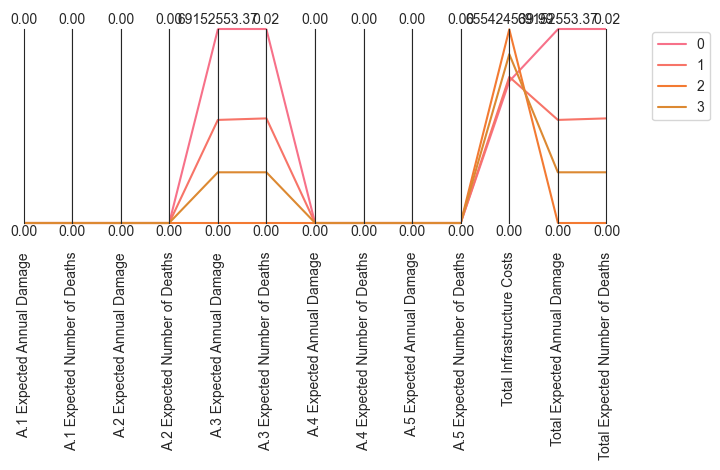

In [16]:
# Drop baseline row
data = outcomes_df.drop(outcomes_df.tail(1).index)
limits = parcoords.get_limits(data)
limits.loc[0, list(outcomes_df.columns)] = 0

# 30 colors, as sns.color_palette() has less than 18 colors.
colors = sns.color_palette("husl", 30)
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.show()

## Plot with 'Policy 0' (the baseline)

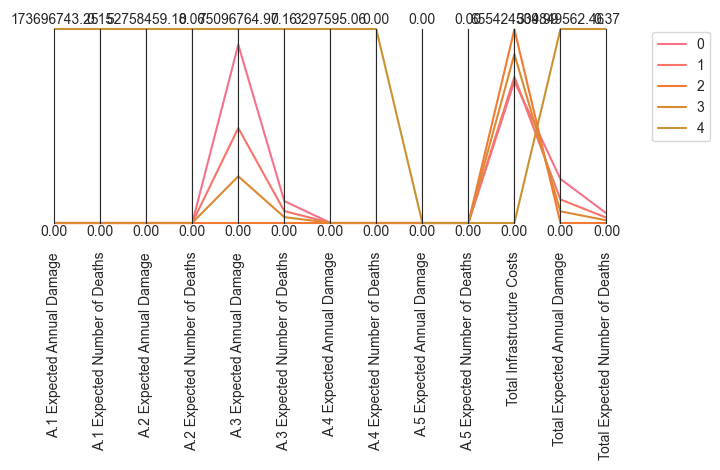

In [17]:
data = outcomes_df
limits = parcoords.get_limits(data)
limits.loc[0, list(outcomes_df.columns)] = 0

# 30 colors, as sns.color_palette() has less than 18 colors.
colors = sns.color_palette("husl", 30)
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.show()

## Apply constraints

In [18]:
# print baseline values
outcomes_df.iloc[len(outcomes_df)-1]

A.1 Expected Annual Damage         1.736967e+08
A.1 Expected Number of Deaths      1.488249e-01
A.2 Expected Annual Damage         5.275846e+07
A.2 Expected Number of Deaths      5.975178e-02
A.3 Expected Annual Damage         7.509676e+07
A.3 Expected Number of Deaths      1.622857e-01
A.4 Expected Annual Damage         3.297595e+06
A.4 Expected Number of Deaths      1.864395e-03
A.5 Expected Annual Damage         0.000000e+00
A.5 Expected Number of Deaths      0.000000e+00
Total Infrastructure Costs         0.000000e+00
Total Expected Annual Damage       3.048496e+08
Total Expected Number of Deaths    3.727268e-01
Name: 4, dtype: float64

### relative constraints vs urban: 

"Similar level of protection as people living in the cities"

1. The ratio of **damages** in ring 4 to damages in ring 3 & ring 5 must be at most as the one in the baseline.
2. The ratio of **deaths** in ring 4 to damages in ring 3 & ring 5 must be at most as the one in the baseline.

### relative constraints vs rural:
"your region should have a lower risk of flood than the industrial farmers"

3. The ratio of **damages** in ring 4 to damages in ring 1 & ring 2 must be at most *80%* of the baseline.
4. The ratio of **deaths** in ring 4 to damages in ring 1 & ring 2 must be at most *80%* of the baseline.

**!!!! we can define these constrainst differently (e.g. focus only of deaths or damages, and choose different ratio thresholds. Note, that these are applied only in the reference scenario - if we later run directed search on multiple scenarios of interest (found by PRIM as part of MS-MORDM, we will need to run this notebook for each scenario.**

**Furthermore, we can apply constrains per single outcome at this point as well !!!**

In [19]:
RATIO=1.25 # 1.25 = 1/0.8

In [20]:
outcomes_df['ratio_damages_vs_urban'] = outcomes_df['A.4 Expected Annual Damage']/ \
    (outcomes_df['A.3 Expected Annual Damage'] + \
     outcomes_df['A.5 Expected Annual Damage'])
outcomes_df['ratio_deaths_vs_urban'] = outcomes_df['A.4 Expected Number of Deaths']/ \
    (outcomes_df['A.3 Expected Number of Deaths'] + \
     outcomes_df['A.5 Expected Number of Deaths'])
outcomes_df['ratio_damages_vs_rural'] = outcomes_df['A.4 Expected Annual Damage']/ \
    (outcomes_df['A.1 Expected Annual Damage'] + \
     outcomes_df['A.2 Expected Annual Damage'])
outcomes_df['ratio_deaths_vs_rural'] = outcomes_df['A.4 Expected Number of Deaths']/ \
    (outcomes_df['A.1 Expected Number of Deaths'] + \
     outcomes_df['A.2 Expected Number of Deaths'])

In [21]:
# these need to be in a separate cell otherwise all defaults to False
outcomes_df['ratio_damages_vs_urban_too_high'] = \
    np.where(outcomes_df['ratio_damages_vs_urban']> \
    outcomes_df.iloc[len(outcomes_df)-1]['ratio_damages_vs_urban'], True, False)
outcomes_df['ratio_deaths_vs_urban_too_high'] = \
    np.where(outcomes_df['ratio_deaths_vs_urban']> \
    outcomes_df.iloc[len(outcomes_df)-1]['ratio_deaths_vs_urban'], True, False)
outcomes_df['ratio_damages_vs_rural_too_high'] = \
    np.where(outcomes_df['ratio_damages_vs_rural']> \
    RATIO*outcomes_df.iloc[len(outcomes_df)-1]['ratio_damages_vs_rural'], True, False)
outcomes_df['ratio_deaths_vs_rural_too_high'] = \
    np.where(outcomes_df['ratio_deaths_vs_rural']> \
    RATIO*outcomes_df.iloc[len(outcomes_df)-1]['ratio_deaths_vs_rural'], True, False)

In [22]:
outcomes_df

,A.1 Expected Annual Damage,A.1 Expected Number of Deaths,A.2 Expected Annual Damage,A.2 Expected Number of Deaths,A.3 Expected Annual Damage,A.3 Expected Number of Deaths,A.4 Expected Annual Damage,A.4 Expected Number of Deaths,A.5 Expected Annual Damage,A.5 Expected Number of Deaths,...,Total Expected Annual Damage,Total Expected Number of Deaths,ratio_damages_vs_urban,ratio_deaths_vs_urban,ratio_damages_vs_rural,ratio_deaths_vs_rural,ratio_damages_vs_urban_too_high,ratio_deaths_vs_urban_too_high,ratio_damages_vs_rural_too_high,ratio_deaths_vs_rural_too_high
0,0.000000e+00,0.000000,0.000000e+00,0.000000,6.915255e+07,0.018217,0.000000e+00,0.000000,0.0,0.0,...,6.915255e+07,0.018217,0.000000,0.000000,NaN,NaN,False,False,False,False
1,0.000000e+00,0.000000,0.000000e+00,0.000000,3.677916e+07,0.009833,0.000000e+00,0.000000,0.0,0.0,...,3.677916e+07,0.009833,0.000000,0.000000,NaN,NaN,False,False,False,False
2,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,...,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,False,False,False,False
3,0.000000e+00,0.000000,0.000000e+00,0.000000,1.805293e+07,0.004756,0.000000e+00,0.000000,0.0,0.0,...,1.805293e+07,0.004756,0.000000,0.000000,NaN,NaN,False,False,False,False
4,1.736967e+08,0.148825,5.275846e+07,0.059752,7.509676e+07,0.162286,3.297595e+06,0.001864,0.0,0.0,...,3.048496e+08,0.372727,0.043911,0.011488,0.014562,0.008939,False,False,False,False


In [23]:
# Keep rows that satisfy all constraints (all False)
kept_rows = outcomes_df[outcomes_df[['ratio_damages_vs_urban_too_high',
                                     'ratio_deaths_vs_urban_too_high',
                                     'ratio_damages_vs_rural_too_high',
                                     'ratio_deaths_vs_rural_too_high'
                                    ]].sum(axis=1) == 0]
# drop Policy 0 (baseline case)
kept_rows.drop(kept_rows.tail(1).index,inplace=True)
kept_rows

,A.1 Expected Annual Damage,A.1 Expected Number of Deaths,A.2 Expected Annual Damage,A.2 Expected Number of Deaths,A.3 Expected Annual Damage,A.3 Expected Number of Deaths,A.4 Expected Annual Damage,A.4 Expected Number of Deaths,A.5 Expected Annual Damage,A.5 Expected Number of Deaths,...,Total Expected Annual Damage,Total Expected Number of Deaths,ratio_damages_vs_urban,ratio_deaths_vs_urban,ratio_damages_vs_rural,ratio_deaths_vs_rural,ratio_damages_vs_urban_too_high,ratio_deaths_vs_urban_too_high,ratio_damages_vs_rural_too_high,ratio_deaths_vs_rural_too_high
0,0.0,0.0,0.0,0.0,6.915255e+07,0.018217,0.0,0.0,0.0,0.0,...,6.915255e+07,0.018217,0.0,0.0,NaN,NaN,False,False,False,False
1,0.0,0.0,0.0,0.0,3.677916e+07,0.009833,0.0,0.0,0.0,0.0,...,3.677916e+07,0.009833,0.0,0.0,NaN,NaN,False,False,False,False
2,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,False,False,False,False
3,0.0,0.0,0.0,0.0,1.805293e+07,0.004756,0.0,0.0,0.0,0.0,...,1.805293e+07,0.004756,0.0,0.0,NaN,NaN,False,False,False,False


In [24]:
# print indices of rows to be kept - these correspond to policies in the initial df.
kept_rows.index

RangeIndex(start=0, stop=4, step=1)

In [25]:
kept_policies = policies.iloc[kept_rows.index]
kept_policies

,Unnamed: 0.1,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,1,0,0,0,0,0,0,...,2,0,0,6,5,3,5,5,5,0
1,1,1,0,1,0,0,0,0,0,0,...,4,1,1,3,3,0,4,4,2,0
2,2,2,0,0,0,0,0,0,1,1,...,4,8,2,1,6,1,1,5,0,4
3,3,3,0,1,0,0,0,0,1,0,...,5,1,3,6,4,1,4,5,1,0


## Save filtered policies

In [26]:
kept_policies.to_csv(INPUT_FILENAME + '_with_constrains.csv')